<a href="https://colab.research.google.com/github/ayusinelnik/narratives-at-conflict/blob/main/10_MFC_XLM_R_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Set Up

In [ ]:
import csv
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from nltk import tokenize
import nltk
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive/', force_remount = True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive/


In [ ]:
!pip install sentencepiece

In [ ]:
# load the codes

import json

json_file_path = '/content/drive/MyDrive/Research_Thesis_Bocconi_2023/mfc_v4.0/codes.json'

with open(json_file_path, 'r') as json_file:
    original_codes_dict = json.load(json_file)
original_codes_dict

In [ ]:
import os

folder_path = '/content/drive/MyDrive/Research_Thesis_Bocconi_2023/mfc_v4.0/'

# Get a list of all files in the folder that end with '_labeled.json'
files = [f for f in os.listdir(folder_path) if f.endswith('_labeled.json')]


merged_data = pd.DataFrame()

# Merge data
for file in files:
    file_path = os.path.join(folder_path, file)
    current_data = pd.read_json(file_path)


    merged_data = pd.concat([merged_data, current_data], axis=1)

merged_data.info()


## Extract the sentences that contain annotation spans

In [ ]:
import pandas as pd
import nltk
import re

nltk.download('punkt')

def extract_framing_text(data):
    extracted_data = []

    for column in data.columns:
        if "framing" in data[column]["annotations"]:
            for annotator, annotations in data[column]["annotations"]["framing"].items():
                print(f"Annotations for column {column} by {annotator}:")
                for annotation in annotations:
                    start = annotation["start"]
                    end = annotation["end"]
                    code = annotation["code"]

                    extracted_sentences = extract_sentences_containing_span(data[column]["text"], start, end)

                    for extracted_sentence in extracted_sentences:

                        extracted_data.append({
                            "column": column,
                            "annotator": annotator,
                            "start": start,
                            "end": end,
                            "code": code,
                            "sentence": extracted_sentence,
                            "original_text": data[column]["text"],
                            "span_text": data[column]['text'][start:end]
                        })


    extracted_df = pd.DataFrame(extracted_data)

    return extracted_df

def extract_sentences_containing_span(text, start, end):

    sentences = nltk.tokenize.sent_tokenize(text)


    span_regex = re.compile(re.escape(text[start:end]), re.IGNORECASE)
    matching_sentences = [sentence for sentence in sentences if span_regex.search(sentence)]

    return matching_sentences

In [ ]:
extracted_data= extracted_data[~extracted_data['code'].astype(str).str.endswith(('.2', '.1'))]

In [ ]:
# filter for 2+ annotator agreement

filtered_data = extracted_data.groupby(['column', 'code', 'sentence']).filter(lambda group: group['annotator'].nunique() >= 2)

## Subsection to create priors from intial distribution of annotations

In [ ]:
#without filtering for examples where the annotators agreed

filtered_data = extracted_data.groupby(['column', 'code', 'sentence']).filter(lambda group: group['annotator'].nunique() >= 1)

In [ ]:
priors = filtered_data['code'].value_counts()

In [ ]:
priors.to_csv('/content/drive/MyDrive/Research_Thesis_Bocconi_2023/results_pairs/priors_unfiltered.csv')

# Train the XML-Roberta-L

In [ ]:
!pip install torch
!pip install transformers

In [ ]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np


In [ ]:
from torch.utils.data import Dataset

In [ ]:
import pandas as pd

Prepare the training files

In [ ]:
filtered_data['code'] = filtered_data['code'].astype(int)
print(filtered_data['code'].unique())

[13  1  6 11  9  3  2 14 10  5 12  8  7  4]


In [ ]:
data = filtered_data

train_data, val_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

train_data_formatted = [{"text": text, "label": label} for text, label in zip(train_data['sentence'], train_data['code'])]
val_data_formatted = [{"text": text, "label": label} for text, label in zip(val_data['sentence'], val_data['code'])]

In [ ]:
# Load XLM-Roberta tokenizer and model

model_name = 'xlm-roberta-large'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
base_model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=15)
hidden_size = base_model.config.hidden_size

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

classifier = torch.nn.Sequential(
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 15)
)

model = torch.nn.Sequential(base_model, classifier)

# Modify the final classifier layer
classifier = torch.nn.Sequential(
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 15)
)

class CustomModel(torch.nn.Module):
    def __init__(self, base_model, classifier):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.classifier = classifier

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        if labels is not None:
            loss = outputs.loss
            return loss
        return logits

model = CustomModel(base_model, classifier)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(item["text"], truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }

In [ ]:
train_dataset = CustomDataset(train_data_formatted, tokenizer, max_length=70)
val_dataset = CustomDataset(val_data_formatted, tokenizer, max_length=70)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
learning_rate = 5e-6
num_epochs = 20
warmup_steps = 0.05 * len(train_loader)
total_steps = num_epochs * len(train_loader)
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
best_macro_f1 = 0.0

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Extract the loss from the outputs
        loss = outputs if labels is not None else None

        if loss is not None:
            loss.backward()
            optimizer.step()
            scheduler.step()


    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        print(f'Epoch {epoch + 1}/{num_epochs}, Macro F1: {macro_f1}')


        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model_checkpoint.pth')


torch.save(model.state_dict(), '/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model.pth')

Load from a checkpoint

In [ ]:
best_macro_f1 = 0.0


model.load_state_dict(torch.load('/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model_checkpoint.pth'))
model.to(device)


for epoch in range(num_epochs - 8):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)


        loss = outputs if labels is not None else None

        if loss is not None:
            loss.backward()
            optimizer.step()
            scheduler.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        print(f'Epoch {epoch + 9}/{num_epochs}, Macro F1: {macro_f1}')


        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model_checkpoint.pth')


torch.save(model.state_dict(), '/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model.pth')

# Test the Model on an Example

In [ ]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import numpy as np


model_name = 'xlm-roberta-large'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
base_model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=15)


classifier = torch.nn.Sequential(
    torch.nn.Linear(base_model.config.hidden_size, base_model.config.hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(base_model.config.hidden_size, 15)  # 15 classes
)


class CustomModel(torch.nn.Module):
    def __init__(self, base_model, classifier):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.classifier = classifier

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        if labels is not None:
            loss = outputs.loss
            return loss
        return logits

model = CustomModel(base_model, classifier)


model.load_state_dict(torch.load('/content/drive/MyDrive/Research_Thesis_Bocconi_2023/park_xlmrl_best_model_checkpoint.pth', map_location=torch.device('cpu')))
model.eval()


In [ ]:

# Example sentence for prediction
example_sentence = "This is an example senten about ethics, morality and values."


input_ids = tokenizer.encode(example_sentence, return_tensors="pt")
attention_mask = torch.ones(input_ids.shape, device=input_ids.device)

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask)


probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()


print("Example Sentence:", example_sentence)
print("Predicted Class:", predicted_class)
print("Class Probabilities:", probs.tolist())


Example Sentence: This is an example senten about ethics, morality and values.
Predicted Class: 3
Class Probabilities: [[8.453911505057476e-06, 0.0002395718329353258, 3.020198164449539e-05, 0.998698353767395, 0.00012554157001432031, 8.547297329641879e-05, 8.581209112890065e-05, 0.0002171618543798104, 9.797385428100824e-05, 0.00011284122592769563, 4.876940147369169e-05, 2.3209835489979014e-05, 4.301615626900457e-05, 0.00016813019465189427, 1.555299422761891e-05]]


# Evaluate on the Test Set

Merge all the excels with annotations

In [ ]:
import os

folder_path = '/content/drive/MyDrive/Research_Thesis_Bocconi_2023/annotations/annotations_sentences_park_2022/task_for_annotators/'

files = [f for f in os.listdir(folder_path) if f.endswith('_corrected.xlsx')]

annotations = pd.DataFrame()

for file in files:
    file_path = os.path.join(folder_path, file)
    current_data = pd.read_excel(file_path)

    annotations = pd.concat([annotations, current_data], axis=0, ignore_index=True)

annotations.info()


In [ ]:
annotations['code'] = annotations['annotations'].apply(lambda x: next((k for k, v in original_codes_dict.items() if str(v) == str(x)), x))
annotations['code'] = annotations['code'].astype(int)

In [ ]:
# we don't measure 'Other' frame
annotations = annotations[annotations['code'] != 15]

Translate

In [ ]:
!pip install python-dotenv

In [ ]:
import pandas as pd
from google.cloud import translate_v2 as translate
import os
from dotenv import load_dotenv

load_dotenv()

def translate_text_google_api(text, target_language='en'):
    try:
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""
        client = translate.Client()

        result = client.translate(text, target_language=target_language)
        translation = result['translatedText']
        return translation
    except Exception as e:
        print(f"Translation error for '{text}': {e}")
        return None

def translate_texts_google_api(texts, target_language='en'):
    translations = []
    for text in texts:
        translation = translate_text_google_api(text, target_language)
        translations.append(translation)
    return translations

annotations['sentence_trans'] = translate_texts_google_api(annotations['target_sentence'])




In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        encoding = self.tokenizer(item["sentence_trans"], truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(item["code"], dtype=torch.long)  # Assuming 'code' is the correct label column
        }


In [ ]:

from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, f1_score
device = 'cpu'


model.eval()

test_dataset = CustomDataset(annotations, tokenizer, max_length=70)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        y_true_list.extend(labels.cpu().numpy())
        y_pred_list.extend(preds.cpu().numpy())

class_metrics = precision_recall_fscore_support(y_true_list, y_pred_list, labels=list(set(y_true_list)), zero_division=1)

for i, label in enumerate(list(set(y_true_list))):
    print(f"\nClass: {label}")
    print(f"Precision: {class_metrics[0][i]}")
    print(f"Recall: {class_metrics[1][i]}")
    print(f"F1 Score: {class_metrics[2][i]}")
    print(f"Support: {class_metrics[3][i]}")


macro_f1 = f1_score(y_true_list, y_pred_list, average='macro')
print("\nOverall Macro F1 Score:", macro_f1)



Class: 1
Precision: 0.5
Recall: 0.5714285714285714
F1 Score: 0.5333333333333333
Support: 7

Class: 2
Precision: 1.0
Recall: 0.08333333333333333
F1 Score: 0.15384615384615385
Support: 12

Class: 3
Precision: 1.0
Recall: 0.6
F1 Score: 0.7499999999999999
Support: 5

Class: 4
Precision: 0.3333333333333333
Recall: 0.125
F1 Score: 0.18181818181818182
Support: 8

Class: 5
Precision: 0.3333333333333333
Recall: 0.16666666666666666
F1 Score: 0.2222222222222222
Support: 6

Class: 6
Precision: 0.3333333333333333
Recall: 0.1111111111111111
F1 Score: 0.16666666666666666
Support: 9

Class: 7
Precision: 0.16666666666666666
Recall: 0.2
F1 Score: 0.1818181818181818
Support: 5

Class: 8
Precision: 0.2857142857142857
Recall: 0.35294117647058826
F1 Score: 0.31578947368421056
Support: 17

Class: 9
Precision: 0.2857142857142857
Recall: 0.6666666666666666
F1 Score: 0.4
Support: 3

Class: 10
Precision: 0.6
Recall: 0.2727272727272727
F1 Score: 0.37499999999999994
Support: 11

Class: 11
Precision: 0.43902439024

Generate a Confusion Matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


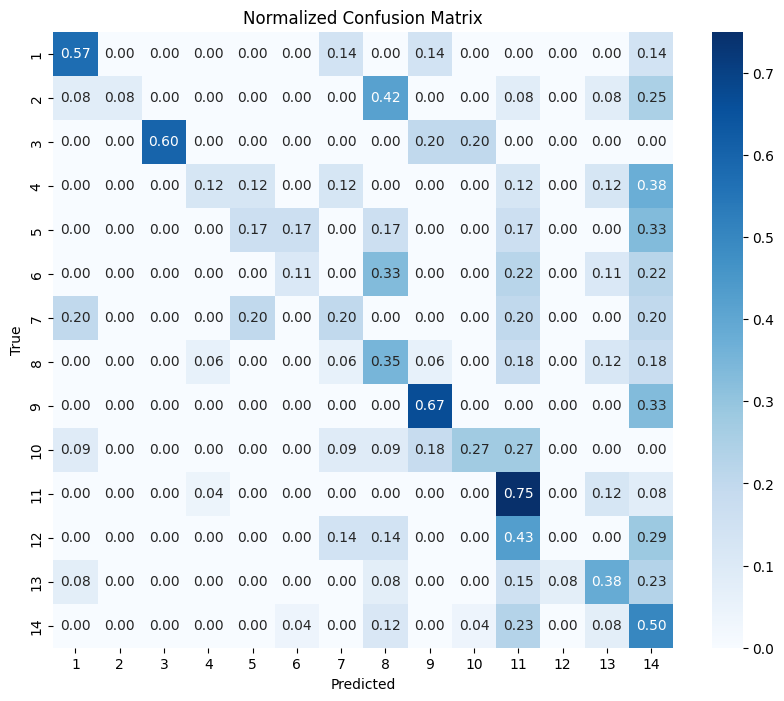

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive



conf_matrix = confusion_matrix(y_true_list, y_pred_list, labels=list(set(y_true_list)))
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
non_zero_mask = conf_matrix_normalized != 0.00

labels = [label for label in set(y_true_list) if any(conf_matrix_normalized[list(set(y_true_list)).index(label), :])]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

Investigate the problematic codes

In [ ]:
class_12_indices = [i for i, label in enumerate(y_true_list) if label == 12]

print("Number of instances for Class 12:", len(class_12_indices))

print("\nTrue Labels for Class 12:", [y_true_list[i] for i in class_12_indices])
print("Predicted Labels for Class 12:", [y_pred_list[i] for i in class_12_indices])

sentences_class_12 = [annotations.iloc[i]['sentence_trans'] for i in class_12_indices]
print("\nSentences for Class 12:")
for i, sentence in enumerate(sentences_class_12):
    print(f"{i + 1}. {sentence}")


Number of instances for Class 12: 7

True Labels for Class 12: [12, 12, 12, 12, 12, 12, 12]
Predicted Labels for Class 12: [11, 14, 11, 8, 14, 7, 11]

Sentences for Class 12:
1. In relation to Russia, a split is visible in Romanian society: the upper classes are pro-Western and Russophobic, the lower classes are relatively Russophile and anti-Ukrainian.
2. The world hangs by a thread.
3. And even if they don’t do this, and continue to front - There is a continuum between the sixth and fifth columns
4. It&#39;s not even 9/11.
5. But all this evidence was not enough for the Western media, which to this day continue to blame Russia for this tragedy.
6. The fate of the sixth column: when will it be fulfilled? As for it, the authorities seem to have made up their minds
7. Today it is evident to the whole world: Western civilization has gone mad.
